In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from ici_mwi_alone import iciData

In [2]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])


batchSize = 128

depth  = 4
width  = 128
convergence_epoch = 6
maximum_epoch = 100


In [3]:
targets = [ 'I1V', 'I2V', 'I3V', 'MWI-15', 'MWI-16' ]
inChannels = np.array([ 'I1V','I2V', 'I3V', 'MWI-15', 'MWI-16'])
#inChannels = np.array(['I1V', 'I2V', 'I3V', 'MWI-15', 'MWI-16', 'I5V', 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])

#inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])

In [4]:
def train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data):
        qrnn = QRNN(inputs, quantiles, (depth, width , "relu"))
        for lr in [ 0.01, 0.001, 0.0001]:
            print ("NEW LEARNING RATE")
            results = qrnn.train(
                training_data,
                validation_data,
                batch_size=batchSize,
                momentum = 0,
                sigma_noise=None,
                initial_learning_rate= lr ,
                maximum_epochs=maximum_epoch,
                convergence_epochs= convergence_epoch,    
                gpu=True)

        return results, qrnn

### read data

In [5]:
for target in targets:
    

#    inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V'])
    print ('doing target ',target)
    inChannels = np.array([ 'I1V', 'I2V', 'I3V', 'MWI-15', 'MWI-16'])
    data = iciData("TB_ICI_mwi_train.nc", 
                   inChannels, target, 
                   batch_size = batchSize)   
    inputs = len(inChannels)

    n = len(data)
    n_train = int(0.9 * n)
    n_val = n - n_train
    training_data, validation_data = random_split(data, [n_train, n_val])
    results = []
    results, qrnn = train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data)
    qrnn.save('qrnn_ici_%s_%s_%s_mwi-alone.nc'%(str(depth),str(width),target))
#    qrnn.save('qrnn_ici_%s_%s_%s.nc'%(str(depth),str(width),target))

doing target  I1V
NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



doing target  I2V
NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



doing target  I3V
NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



doing target  MWI-15
NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



doing target  MWI-16
NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE


### begin training

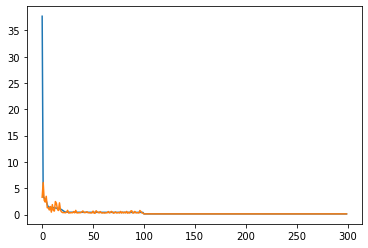

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(results['training_errors'])
ax.plot(results['validation_errors'])


In [7]:
target = 'MWI-16'
data = iciData("TB_ICI_mwi_test.nc", 
               inChannels, target, 
               batch_size = batchSize)   
inputs = len(inChannels)

n = len(data)
n_train = int(0.05 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])

### plot calibration plot

Text(0, 0.5, 'Observed frequency')

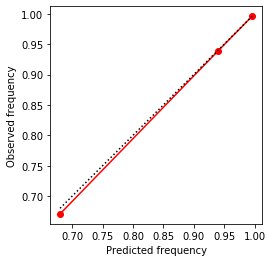

In [8]:
#filename = "option4_qrnn_models/qrnn_%s_%s_%s.nc" % (str(nn_depth), str(128), str(inChannels[0]))
#print(filename)

qrnn = QRNN.load('qrnn_ici_%s_%s_%s_mwi-alone.nc'%(str(depth),str(width),target))
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")

In [9]:
itarget = np.argwhere(inChannels == target)[0]

In [10]:
y_pre = []
y = []
y_prior = []
y_pos_mean = []
x_in = []

nbatch = validation_data.__len__()
print (nbatch)
for i in range(nbatch):
    
    xx, yy = validation_data.__getitem__(i)
    
    x = xx.detach().numpy() 

    y_prior.append((x * data.std) + data.mean)
#    y_prior.append((x[:, 0]))

    y_pre.append(qrnn.predict(x)) 
    y_pos_mean.append((qrnn.posterior_mean(x)))
       
    y.append(yy.detach().numpy())
    x_in.append(x)

326


In [11]:
itarget

array([4])

In [12]:
x_in = np.concatenate(x_in, axis = 0)
y_pre = np.concatenate(y_pre, axis = 0)
y = np.concatenate(y, axis= 0)
y_prior = np.concatenate(y_prior, axis = 0)
y_pos_mean = np.concatenate(y_pos_mean, axis = 0)

dtb_max_meas = 15

#im = np.abs(y_prior[:, itarget[0]] - y_prior[:, itarget[0]]) <= dtb_max_meas 

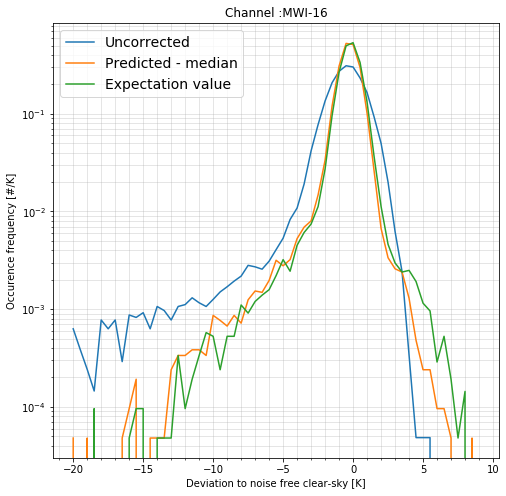

In [13]:
dtb_pre = y_pre[:, 3] - y
dtb_prior = y_prior[:, itarget[0]] - y
dtb_pos_mean = y_pos_mean - y

binstep = 0.5
bins = np.arange(-20, 10, binstep)
hist_pre = np.histogram(dtb_pre, bins, density = True)
hist_prior = np.histogram(dtb_prior, bins, density = True)
hist_pos_mean = np.histogram(dtb_pos_mean, bins, density = True)


fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(bins[:-1], hist_prior[0])
ax.plot(bins[:-1], hist_pre[0])
ax.plot(bins[:-1], hist_pos_mean[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)
ax.set_title("Channel :%s"%target)
ax.legend(["Uncorrected", "Predicted - median", "Expectation value"], prop={'size': 14})
fig.savefig('ICI_%s_single.png'%target)